# Load the features and initialize the constants

In [125]:
import os
import json
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as kb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing


from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, concatenate, LSTM
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

import pydot, graphviz
import keras
import pydotplus
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [229]:
#Load all labels
labels = dict()
files = os.listdir('../../Data/Labels/')
for file in files:
    if '.npy' not in file:
        continue
    vid = file.split('.')[0]
    labels[vid] = np.load(f'../../Data/Labels/{file}')

In [230]:
#Load all text feature files
txt_features = dict()
files = os.listdir('../../Data/Text/text_data/')
for file in files:
    if '.npy' not in file:
        continue
    vid = file.split('.')[0]
    txt_features[vid] = np.load(f'../../Data/Text/text_data/{file}')

In [232]:
#Video ids to be used
with open("../../Data/video_ids_balanced.json", "r") as f:
    ids_balanced = json.load(f)
ids_balanced = [vid[:-4] for vid in ids_balanced]
    
available_video_ids = list(labels.keys())
available_txt_ids = list(txt_features.keys())
common_ids = set(available_txt_ids).intersection(set(available_video_ids))
common_ids = list(common_ids.intersection(set(ids_balanced)))

common_ids_count = len(common_ids)
split = (common_ids_count*80)//100
train_ids, test_ids = common_ids[:split], common_ids[split:]

In [233]:
def get_labels(trains_ids, test_ids):
    y_train = [labels[vid] for vid in train_ids]
    y_test = [labels[vid] for vid in test_ids]
    
    return y_train, y_test

def get_text_data(ids):
    data = [txt_features[vid] for vid in ids]
    
    return data

# return data given a list of video ids
# output data is the shape of (number of ids, num frames, num features)
# in our case, num frames = 800 and num features = 13
def get_audio_data(id_list):
    audio_data = pd.read_csv('../../Data/Audio/audio_data.csv').values
    audio_ids = pd.read_json('../../Data/video_ids_balanced.json')
    audio_ids = audio_ids.values.squeeze()
    audio_ids = [aid[:-4] for aid in audio_ids]

    id_dict = {aid:idx for idx, aid in enumerate(audio_ids)}
    data = audio_data.reshape((len(audio_ids), 800, audio_data.shape[1]))
    
    id_idx = [id_dict[i] for i in id_list]
    
    output_data = data[id_idx,:,:]

    return output_data

#Get Data, Scale Data, Return data
def get_video_data(train_ids, test_ids):
    X_train = df_vids[df_vids['video_id'].isin(train_ids)][['video_id']+training_features]
    X_test = df_vids[df_vids['video_id'].isin(test_ids)][['video_id']+training_features]
    
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train[training_features])
    
    X_train_scaled, X_test_scaled = dict(), dict()
    y_train, y_test = list(), list()
    
    for vid, _df in X_train.groupby('video_id'):
        X_train_scaled[vid] = scaler.transform(_df[training_features])
    X_train_scaled = [X_train_scaled[vid] for vid in train_ids]
    
    for vid, _df in X_test.groupby('video_id'):
        X_test_scaled[vid] = scaler.transform(_df[training_features])
    X_test_scaled = [X_test_scaled[vid] for vid in test_ids]
     
    return X_train_scaled, X_test_scaled

def z_scale(train_data, test_data):
    scaler = preprocessing.StandardScaler()
    samples, frames, features = train_data.shape
    
    train_data = train_data.reshape((samples*frames, features))
    train_data = scaler.fit_transform(train_data)
    train_data = train_data.reshape((samples, frames, features))
    
    samples, frames, features = test_data.shape
    test_data = test_data.reshape((samples*frames, features))
    test_data = scaler.transform(test_data)
    test_data = test_data.reshape((samples, frames, features))
    
    return train_data, test_data

# Visual Features

In [237]:
# ---------------------------------------
# Read feature names
# ---------------------------------------

f = open("../../Data/Visual/openface_feature_names.json", "r")
all_features = json.load(f)
f.close()

#Regex to link feature names to what they represent
feature_regex = {
    "action_units": ['AU'],
    "gaze": ['gaze'],
    "shape": ['p_'],
    "landmarks_2d": [' x_', ' y_'],
    "landmarks_3d": [' X_', ' Y_', ' Z_'],
    "eye_lmk_2d": ["lmk_x", "lmk_y"],
    "eye_lmk_3d": ["lmk_X", "lmk_Y", "lmk_Z"],
    "output": ["rating"]
}
features = defaultdict(list)
for feature, regexes in feature_regex.items():
    for col in all_features:
        for regex in regexes:
            if regex in col:
                features[feature].append(col)

#Features to use for training
training_features = ['landmarks_2d']
training_features = [ftr_name for feature in training_features for ftr_name in features[feature]][:5]

#del df_vids
df_vids = pd.read_csv("../../Data/Visual/openface_features.csv", usecols=['video_id']+training_features)

feature_indices = sorted([all_features.index(feature) for feature in training_features])

#Constants
FEATURE_INDICES = feature_indices
MAX_FRAMES_PER_VIDEO = 600 #Pad/Truncate data to maitain 800 frames
FEATURE_COUNT = len(FEATURE_INDICES)
print("Number of features used for training : ", FEATURE_COUNT)

Number of features used for training :  5


# Text

In [238]:
GLOVE_DIR = '../../Data/Text/glove.twitter.27B'
EMBEDDING_DIM = 200

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.200d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 1193514 word vectors.


In [239]:
#Constants
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 1500

In [240]:
word_index = np.load('../../Data/Text/word_index.npy', allow_pickle=True)
word_index = word_index.item()
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Get data for all modalities

In [241]:
X_train_video, X_test_video = get_video_data(train_ids, test_ids)

X_train_text, X_test_text = get_text_data(train_ids), get_text_data(test_ids)

X_train_audio, X_test_audio = get_audio_data(train_ids), get_audio_data(test_ids)
X_train_audio, X_test_audio = z_scale(X_train_audio, X_test_audio)

y_train, y_test = get_labels(train_ids, test_ids)

In [242]:
X_train_video = [tf.keras.preprocessing.sequence.pad_sequences([ftrs], maxlen=MAX_FRAMES_PER_VIDEO, 
                                                             dtype='float64', padding='post', 
                                                               truncating='pre', value=0.0)[0] for ftrs in X_train_video]
X_test_video = [tf.keras.preprocessing.sequence.pad_sequences([ftrs], maxlen=MAX_FRAMES_PER_VIDEO, 
                                                             dtype='float64', padding='post', 
                                                               truncating='pre', value=0.0)[0] for ftrs in X_test_video]

In [243]:
print(X_train_audio.shape)

(768, 800, 13)


# Deep Learning

In [249]:
#Visual
#model = generate_model(MAX_FRAMES_PER_VIDEO, FEATURE_COUNT)

#Text
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name="input2")
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu', kernel_regularizer=l1_l2(l1=1.e-12, l2=1.e-12))(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu', kernel_regularizer=l1_l2(l1=1.e-12, l2=1.e-12))(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu', kernel_regularizer=l1_l2(l1=1.e-12, l2=1.e-12))(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(100, activation='relu')(x)

#Visual
visual_input = Input(shape=(MAX_FRAMES_PER_VIDEO, FEATURE_COUNT), name="input1")
secondary_layer = LSTM(100, return_sequences=False)(visual_input)
dense_visual = Dense(100)(secondary_layer)

#Audio
audio_input = Input(shape=(800, 13), name="input3")
#secondary_layer_audio = LSTM(100, return_sequences=False)(audio_input)
l1 = Dense(300, activation='relu')(audio_input)
l2 = Dense(150, activation='relu')(l1)
l3 = LSTM(100, return_sequences=False)(l2)
dense_audio = Dense(100)(l3)


In [250]:
#Multimodal
merged_layers = concatenate([x, dense_visual, dense_audio])
preds = Dense(1, activation='linear')(merged_layers)

model = Model([sequence_input, visual_input, audio_input], preds)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

print(model.summary())
#plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input2 (InputLayer)             [(None, 1500)]       0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 1500, 200)    24280600    input2[0][0]                     
__________________________________________________________________________________________________
conv1d_39 (Conv1D)              (None, 1496, 128)    128128      embedding_13[0][0]               
__________________________________________________________________________________________________
max_pooling1d_39 (MaxPooling1D) (None, 299, 128)     0           conv1d_39[0][0]                  
___________________________________________________________________________________________

In [251]:
history = model.fit({'input1':tf.convert_to_tensor(X_train_video), 
                     'input2':tf.convert_to_tensor(X_train_text),
                     'input3':X_train_audio}, 
                    tf.convert_to_tensor(y_train), epochs=100, batch_size=64, validation_split=0.1)

Train on 691 samples, validate on 77 samples
Epoch 1/100
691/691 [==============================] - 55s 80ms/sample - loss: 0.1514 - root_mean_squared_error: 0.3891 - val_loss: 0.0708 - val_root_mean_squared_error: 0.2662
Epoch 2/100
691/691 [==============================] - 20s 29ms/sample - loss: 0.0782 - root_mean_squared_error: 0.2796 - val_loss: 0.0733 - val_root_mean_squared_error: 0.2708
Epoch 3/100
691/691 [==============================] - 22s 32ms/sample - loss: 0.0730 - root_mean_squared_error: 0.2701 - val_loss: 0.0734 - val_root_mean_squared_error: 0.2710
Epoch 4/100
691/691 [==============================] - 40s 57ms/sample - loss: 0.0676 - root_mean_squared_error: 0.2601 - val_loss: 0.0769 - val_root_mean_squared_error: 0.2773
Epoch 5/100
691/691 [==============================] - 61s 88ms/sample - loss: 0.0662 - root_mean_squared_error: 0.2573 - val_loss: 0.0803 - val_root_mean_squared_error: 0.2833
Epoch 6/100
691/691 [==============================] - 36s 52ms/sample

KeyboardInterrupt: 

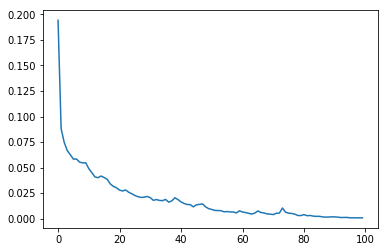

In [206]:
plt.plot(history.history['loss'])

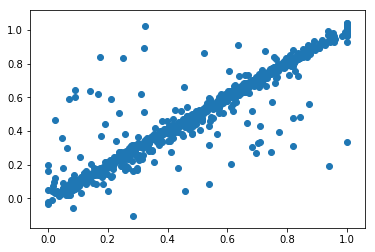

In [207]:
results = model.predict({"input1":tf.convert_to_tensor(X_train_video), 
                         "input2":tf.convert_to_tensor(X_train_text),
                         "input3":tf.convert_to_tensor(X_train_audio)})
results = results.reshape(-1)
plt.scatter(y_train, results)

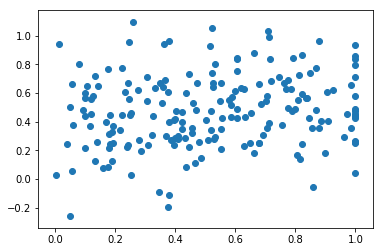

In [208]:
results = model.predict({"input1":tf.convert_to_tensor(X_test_video), 
                         "input2":tf.convert_to_tensor(X_test_text),
                         "input3":tf.convert_to_tensor(X_test_audio)})
results = results.reshape(-1)
plt.scatter(y_test, results)

In [227]:
print(f"Test MSE = {tf.keras.losses.MSE(y_test, results).numpy()}")

Test MSE = 0.1239708885550499


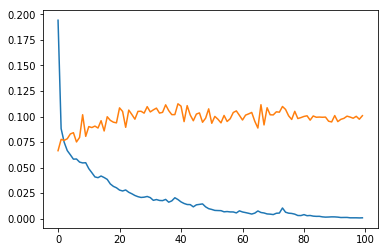

In [213]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])